This notebook is an example of how to create initial conditions for merger events using PCHTrees and a few routines from SatGen.

Requirements:
 - an environment capable of running SatGen (although we don't run SatGen itself, the SatGen routines we use depend on various other packages).
 - an "updated" version of SatGen compatible with recent versions of `numpy`.
 - `pytables` (could be replaced with h5py by editing the read_hdf5 function below)

In [1]:
%config InlineBackend.figure_format="retina"
%config Completer.use_jedi = False

In [2]:
pwd

'/data/apcooper/projects/sgarrak/notebooks/ics_example'

In [3]:
import sys
import os
import time

import numpy as np
import tables as tb
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import astropy.cosmology as cosmo

from astropy.table import Table

import copy

SATGEN_PATH = '/data/apcooper/sfw/SatGen'
if not SATGEN_PATH in sys.path:
    sys.path.append(SATGEN_PATH)

SATGEN_ETC_PATH = '/data/apcooper/sfw/SatGen/etc'
if not SATGEN_ETC_PATH in sys.path:
    sys.path.append(SATGEN_ETC_PATH)
        
# SatGen Imports
import config as cfg
import cosmo as co
import evolve as ev
from   profiles import NFW,Dekel,MN,Einasto,Green
from   orbit import orbit
import galhalo as gh
import aux
import init

>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8000.
>>> Building interpolation grid for Green+19 M(<r|f_b,c)...
>>> Building interpolation grid for Green+19 sigma(r|f_b,c)...
>>> Building interpolation grid for Green+19 d2Phidr2(r|f_b,c)...
>>> Building interpolator for Jiang+15 orbit sampler...
[0.  0.5 1.  1.5]


In [4]:
import matplotlib.pyplot as pl
%matplotlib inline

In [5]:
def read_hdf5(path,datasets,group='/'):
    with tb.open_file(path, 'r') as f:
        if isinstance(datasets,str):
            # Just one dataset, read it as an array
            data = f.get_node(f'{group}/{datasets}').read()
        else:
            # Assume nodes is an iterable of dataset names under group
            data = dict([ (name,f.get_node(f'{group}/{name}').read()) for name in datasets])
    return data

### Generate PCHTrees output

In [6]:
# Millennium Cosmology (should match whatever was used in PCHTrees)
hubble_parameter = 0.73
cosmology = cosmo.FlatLambdaCDM(hubble_parameter*100,0.25)

This notebook will use the example tree run in `./trees/`, under the directory containing this notebook. After compiling `pchtrees`, follow the README.md in that directory to create the trees.

This should generate `./trees/output_progenitors_100_mw.hdf5`. This file contains only the "first order progenitors" and main branch mass histories, not the full trees.

In [7]:
!ls ./trees

output_progenitors_100_mw.hdf5	run_pchtrees_pfop_100_mw.sh
pchtrees			satgen_level_zred_100myr_z3_z12.txt
pchtrees_pfop_100_mw.toml	slurm_run_pchtrees_pfop_100_mw.sh
README.md


In [8]:
!h5ls ./trees/output_progenitors_100_mw.hdf5/Progenitors

HostMass                 Dataset {24754/Inf}
MergedMass               Dataset {24754/Inf}
MergedZred               Dataset {24754/Inf}
ProgenitorIlev           Dataset {24754/Inf}
ProgenitorMass           Dataset {24754/Inf}
ProgenitorZred           Dataset {24754/Inf}
TreeID                   Dataset {24754/Inf}


In [9]:
# Output of PCHTrees
tree_file = './trees/output_progenitors_100_mw.hdf5'

# Read main branch mass histories (immediately deal with little h)
tree_main_branch_masses = read_hdf5(tree_file,'/Mainbranch/MainbranchMass')/hubble_parameter

# Number of treees and tree levels
ntrees, nlev = tree_main_branch_masses.shape

# Read progenitor data (immediately deal with little h on masses)
progenitor_dataset_names = ["HostMass","ProgenitorZred","ProgenitorMass","ProgenitorIlev","TreeID"]
    
progenitors = read_hdf5(tree_file, progenitor_dataset_names, group='/Progenitors')
progenitors['ProgenitorMass'] = progenitors['ProgenitorMass']/hubble_parameter
progenitors['HostMass']       = progenitors['HostMass']/hubble_parameter

tree_redshifts = read_hdf5(tree_file,'Redshift',group='/OutputTimes')
tree_t_lbk_gyr = cosmology.lookback_time(tree_redshifts).value
tree_t_age_gyr = cosmology.age(tree_redshifts).value

# Root mass is the the mass of the main branch at z=0
root_mass = tree_main_branch_masses[:,0]

### Explore the progenitor file

The following cells make plots of basic quantities for one of the merger trees.

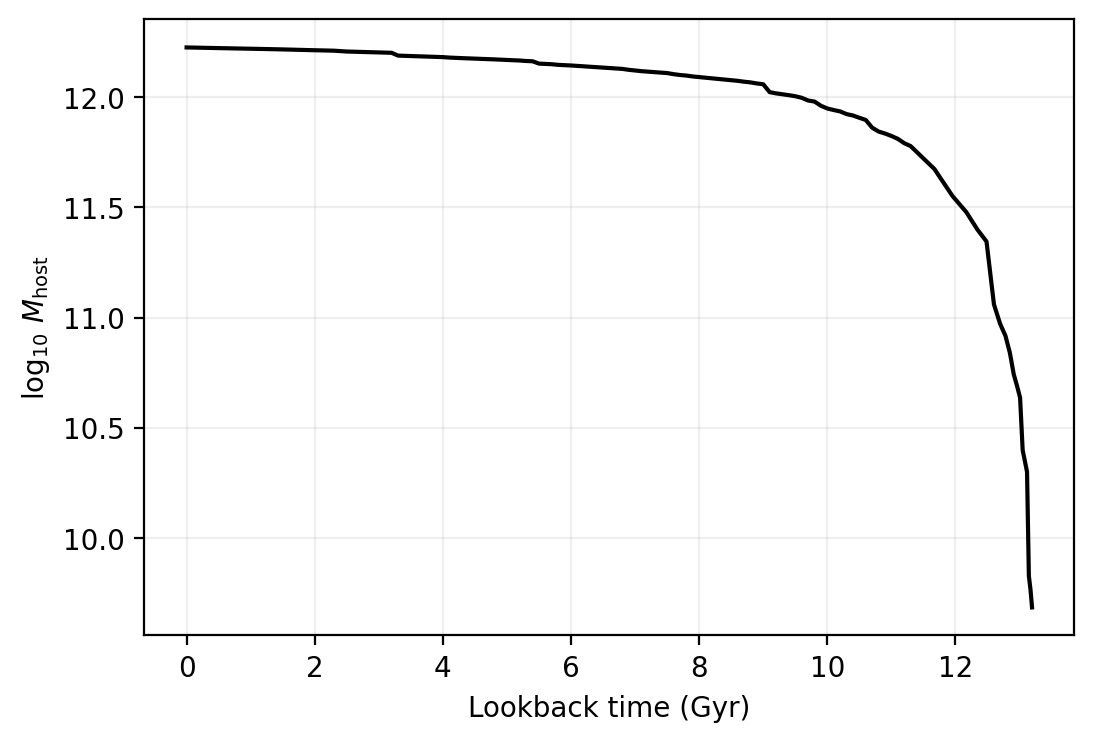

In [10]:
# The main branch mass growth history 

# An example tree
itree = 0

pl.figure(figsize=(6,4))
pl.plot(tree_t_lbk_gyr, np.log10(tree_main_branch_masses[itree,:]),c='k')
pl.grid(alpha=0.2)
pl.xlabel('Lookback time (Gyr)')

pl.ylabel('$\log_{10}\,M_\mathrm{host}$');

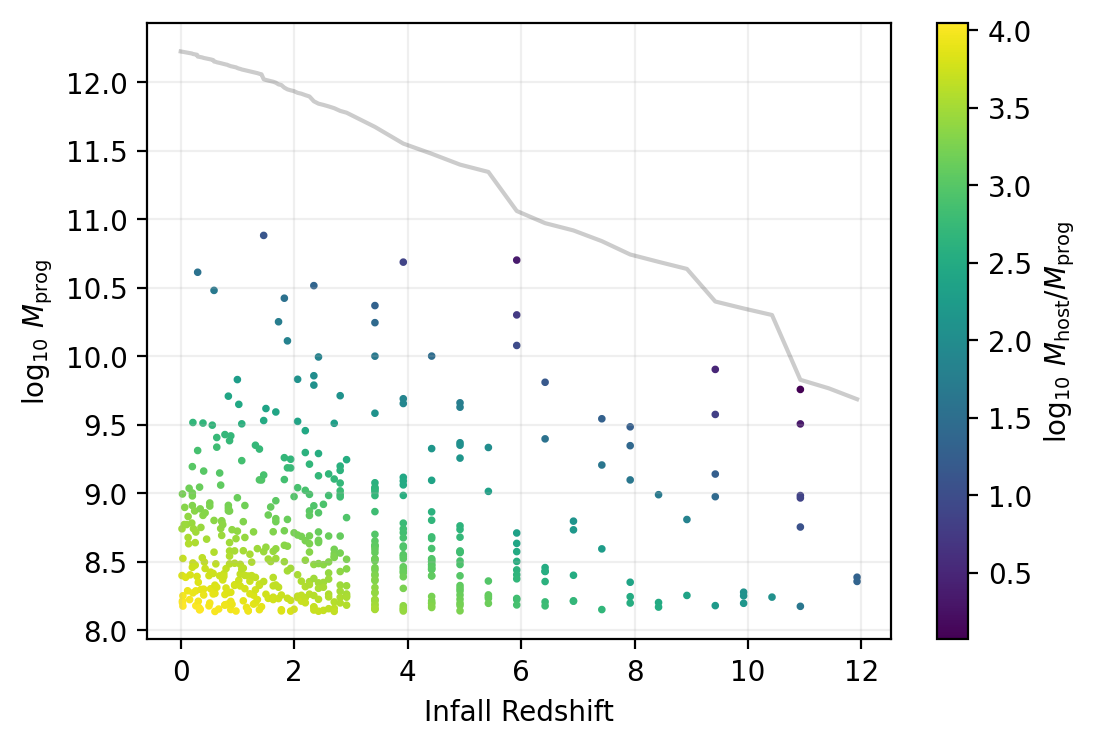

In [11]:
# Scatterplot progenitor masses and infall redshifts

# An example tree
itree = 0

prog_this_tree = np.flatnonzero(progenitors['TreeID'] == itree)

prog_zred = progenitors['ProgenitorZred'][prog_this_tree]
prog_ilev = progenitors['ProgenitorIlev'][prog_this_tree] 
prog_logm = np.log10(progenitors['ProgenitorMass'][prog_this_tree])

# Get the host mass at the infall redshift
host_mass = tree_main_branch_masses[itree,:]
host_logm_infall = np.log10(host_mass[prog_ilev])

logm_ratio = host_logm_infall - prog_logm

pl.figure(figsize=(6,4))
pl.scatter(prog_zred, 
           prog_logm,
           c=logm_ratio,
           s=3)
pl.colorbar(label='$\log_{10}\,M_\mathrm{host}/M_\mathrm{prog}$')

pl.plot(tree_redshifts, np.log10(tree_main_branch_masses[itree,:]),c='k',alpha=0.2)

pl.grid(alpha=0.2)
pl.xlabel('Infall Redshift')
pl.ylabel('$\log_{10}\,M_\mathrm{prog}$');

### Generate ICs only (no orbit evolution)

The following functions and classes could be defined in a python module outside this notebook, but for simplicity we collect them here.

In [12]:
def is_iterable(x):
    try:
        iterator = iter(x)
        return True
    except TypeError:
        pass
    return False

In [13]:
def halo_mah_to_zhao_c_nfw(mass, t_age_gyr):
    """
    """
    h_c_nfw = list()
    nlev = mass.shape[0]
    for i in range(0,nlev):
        h_c_nfw.append(init.c2_fromMAH(mass[i:],t_age_gyr[i:]))
    return np.array(h_c_nfw)

In [14]:
class Host():
    def __init__(self, mass, zred, cosmology, output_zred=None):
        """
        output_zred: interpolated if passed
        """
        self.cosmology = cosmology
        self.evolving_mass = is_iterable(mass)

        # The corresponding pairs of mass and zred are usually taken from
        # a merger tree. They should be the same dimension / size.
        if self.evolving_mass:
            assert(is_iterable(zred))
            assert(len(mass) > 1)
            assert(len(zred) == len(mass))
        else:
            assert(not is_iterable(zred))
            assert(output_zred is None)
            
        self._tree_mass = np.atleast_1d(mass)
        self._tree_zred = np.atleast_1d(zred)

        # We need the ages at each tree redshift to compute the concentration
        # evolution with Zhao's method, among other things.
        self._tree_t_age = self.cosmology.age(self._tree_zred).value
        self._tree_t_lbk = self.cosmology.lookback_time(self._tree_zred).value       

        # If timesteps are given, interpolate the discrete merger tree
        # history at those timesteps
        if output_zred is not None:
            if is_iterable(output_zred):
                self._output_zred = np.atleast_1d(output_zred)
                self.interpolated = True
            else:
                raise Exception
        else:
            self._output_zred = None
            self.interpolated = False
            
        # Set the number of tree levels    
        if self.evolving_mass:
            if self.interpolated:
                self.nlev = len(self._output_zred)
            else:
                self.nlev = len(self._tree_mass)
        else:
            self.nlev = 1
            
        # Set the properties at output levels
        if self.interpolated:
            # These are the actual output t_ages, to which we interpolate
            self.zred  = self._output_zred
            self.t_age = self.cosmology.age(self._output_zred).value
            self.mass  = np.interp(self.t_age[::-1], self._tree_t_age[::-1], self._tree_mass[::-1])[::-1] 
            
            self._tree_level_to_output_level = np.digitize(self._tree_t_age,self.t_age)
            self._output_level_to_tree_level = np.digitize(self.t_age,self._tree_t_age)
        else:
            self.t_age = self._tree_t_age
            self.mass  = self._tree_mass
            self.zred  = self._tree_zred
            self._tree_level_to_output_level = np.arange(0,self.nlev)
            
        # Level 0 <=> Latest time (root node)
        
        # We need the lookback times to compute the timesteps
        self.t_lbk = self.cosmology.lookback_time(self.zred).value       
        
        if self.evolving_mass:
            self.concentration = halo_mah_to_zhao_c_nfw(self.mass, self.t_age)
        else:
            self.concentration = np.atleast_1d(init.concentration(self.mass[0], self.zred[0], choice='DM14'))
            
        # Make a profile for each timestep
        self.dens_profile = list()
        for i in range(self.nlev):
             self.dens_profile.append(NFW(self.mass[i],
                                          self.concentration[i],
                                          Delta=200.,
                                          z=self.zred[i],
                                          sf=1.))
        return

In [15]:
class Progenitor():
    def __init__(self, mass, host, 
                 cosmology=None, zred=None, level=None, mstar=None,
                 orbit_init_method='li2020', xc=None, eps=None):
        """
        zred_or_level:
        """
        self.mass_init = mass
        self.mass = self.mass_init
        
        # A progenitor must be associated with a host
        self.host = host
        
        # By default the cosmology is the same as the host!
        if cosmology is not None:
            self.cosmology = cosmology
        else:
            cosmology = host.cosmology
        
        if level is not None:
            # The progenitor infall time is specified by a level (an index in the 
            # list of host masses/redshifts, with level=0 at the root of the tree)
            assert(host.evolving_mass)
            
            self._tree_level = level
            self.zred  = host._tree_zred[ self._tree_level]
            self.infall_t_lbk = host._tree_t_lbk[self._tree_level]            
            
            # In an interpolated tree, the progenitor level should be
            # set to the earlier of whichever two interpolated levels it
            # falls between.
            self.level = host._tree_level_to_output_level[self._tree_level]
            
        elif zred is not None:
            # The progenitor infall time is specified as a redshift.
            self.zred  = zred         
            if host.evolving_mass:
                # This should work even if the host is interpolated at
                # the given zred. Note that this still discretizes
                # the progenitor infall time on whatever is the host
                # redshift grid.
                self.level = np.flatnonzero(host.zred >= self.zred)[0]
            else:
                # There is only one level in a non-evolving host
                self.level = 0
                
            # Starting time for progenitor
            self.infall_t_lbk = cosmology.lookback_time(self.zred).value
        
        # Sanity check for interpolated host
        assert(self.zred <= self.host.zred.max())
        assert(self.zred >  self.host.zred.min())

        self.init_host_dens_profile  = self.host.dens_profile[self.level]
        self.init_host_concentration = self.host.concentration[self.level]

        # Draw progenitor concentration
        self.concentration = init.concentration(self.mass,self.zred,choice='DM14')
        
        # The halo potential is a "Green" profile; an NFW with additional
        # methods to adjust for the effects of tidal stripping.
        self.dens_profile = Green(self.mass,self.concentration,Delta=200,z=self.zred)
        
        # Draw stellar mass from mstar-mhalo releation
        if mstar is None:
            self.mstar_init = init.Mstar(self.mass_init, self.zred, choice='B13')
        else:
            self.mstar_init = mstar
        self.mstar = self.mstar_init
        
        # The mass within rmax is used in the stripping calculations
        self.m_max_init = self.dens_profile.M(self.dens_profile.rmax)
    
        if orbit_init_method is None:
            # xv in cylindrical coordinates: np.array([R,phi,z,VR,Vphi,Vz])  
            self.xc  = xc
            self.eps = eps
            self.xv  = init.orbit(self.init_host_dens_profile, xc=self.xc, eps=self.eps) 
        elif orbit_init_method == 'li2020':
            self.vel_ratio, self.gamma = init.ZZLi2020(self.init_host_dens_profile, 
                                                       self.mass_init, 
                                                       self.zred)
            self.xv = init.orbit_from_Li2020(self.init_host_dens_profile, 
                                             self.vel_ratio, 
                                             self.gamma)
        else:
            raise Exception

        self.r_init = np.sqrt(self.xv[0]**2+self.xv[2]**2)
        return

In [16]:
def evolve_orbit(host, prog, tsteps=None, 
                 evolve_prog_mass=False, 
                 evolve_past_res_limits=False):
    """
    tstep: timesteps measured forwards from the initial conditions at 
        infall. 
           
    evolve_past_res_limits: if True, keep evolving past SatGen resolution
        limits, as set in cfg.phi_res, cfg.Mres and cfg.Rres. If False,
        if any quantity is below the corresponding resolution limit, do
        not compute the orbit, mass loss etc.. Instead, propagate the last
        computed values forward (i.e. repeat them) in the output arrays.
    
    """
    # An enum
    STATUS_PROG_INTACT = 0
    STATUS_PROG_LOST   = 1
    
    # The first entry in the output arrays is the initial conditions
    radii       = [prog.r_init]
    prog_masses = [prog.mass_init]
    prog_mstars = [prog.mstar_init]
    prog_status = [STATUS_PROG_INTACT]
    
    # Working variables
    prog_mass  = prog_masses[0]
    prog_mstar = prog_mstars[0]
    
    prog_mass_init  = prog_mass
    prog_mstar_init = prog_mstar

    # We DO NOT update the host and prog objects in place;
    # Instead make copies.
    host_dp    = copy.deepcopy(prog.init_host_dens_profile)
    prog_dp    = copy.deepcopy(prog.dens_profile)
    
    prog_m_max_init = prog_dp.M(prog_dp.rmax)
    
    hc = prog.init_host_concentration
    pc = prog.concentration
    
    o = orbit(prog.xv)    
    xv     = o.xv 
    r      = np.sqrt(xv[0]**2+xv[2]**2)    
    r_init = r
    
    initial_level = prog.level
    
    # istep = 1 corresponds to evolution from the initial conditions up to the end of the first step 
    # (i.e. from t = 0 up to t = 0 + dt)
    
    # Evolution across the step assumes the host properties to be constant at their intial values.
    # Hence evolution for istep = 1 assumes the host properites to be those at istep = 0
    
    # The timesteps need not be the same as the tree levels (substepping)
   
    # This is the time coordinate of each host level after the initial level, measured from the same
    # t=0 as the orbit evolution timesteps and increasing forwards in time towards the root node.
    host_times_starting_from_initial_level = (host.t_age[:initial_level+1] - host.t_age[initial_level])
    
    # We need to reverse the above, so that the first element corresponds to the infall time 
    # rather than the root of the tree.
    host_times_starting_from_initial_level = host_times_starting_from_initial_level[::-1]

    # Find the reference tree level for each timestep.
    if tsteps is None:
        tsteps = host_times_starting_from_initial_level
        # The reversal is because tree level zero is the root of the tree, not the infall
        # time.
        levels_at_tstep = np.linspace(0,initial_level,initial_level+1,dtype=int)[::-1]        
    else:
        # Interpolate timesteps (t=0 at infall, idx=0) onto grid of tree levels
        # The reversal is because tree level zero is the root of the tree, not the infall
        # time.
        levels_at_tstep = prog.level - (np.searchsorted(host_times_starting_from_initial_level,tsteps,side='right')-1)

    if cfg.Mres is None:
        mres_effective = 0
    else:
        mres_effective = cfg.Mres
        
    nsteps = len(tsteps)
    for istep in range(1,nsteps):    
        t  = tsteps[istep]
        dt = t - tsteps[istep-1]
        
        # Threshold values at resolution limit and skip explicit calculation of remaining steps
        # (i.e. propagate values at resolution limit forward.
        if (prog_mass <= mres_effective) or (r <= cfg.Rres) or ((prog_mass/prog_mass_init) <= cfg.phi_res):
            prog_status.append(STATUS_PROG_LOST)
            if not evolve_past_res_limits:
                radii.append(r)
                prog_masses.append(prog_mass)
                prog_mstars.append(prog_mstar)
                continue 
        else:
            prog_status.append(STATUS_PROG_INTACT)
            
        # Absolute levels in the tree
        start_step_level = levels_at_tstep[istep] - 1
        end_step_level   = start_step_level + 1

        # Update the host profile if needed
        hp = host.dens_profile[start_step_level]
            
        # Evolve the progenitor orbit based on the current mass
        # and host halo profile.
        
        # t is the absolute time over which to integrated from 
        # the initial conditions given. This is somewhat 
        # counter-intuitive because you might think it should
        # be the length of timestep over which to integrate
        # from the current conditions...
        o.integrate(t, host_dp, prog_mass)

        # Note that the coordinates are updated 
        # internally in the orbit instance "o" when calling
        # the ".integrate" method, here we assign them to 
        # a new variable "xv" only for bookkeeping
        xv  = o.xv 
        r   = np.sqrt(xv[0]**2+xv[2]**2)
        radii.append(r)
        
        if evolve_prog_mass:
            # Evolve the progenitor mass for dt in the current potential
            # Following SatGen (SatEvo), msub takes the initial potentials
            # and orbit at the start of the step.
            # dt is the length of the step (right? APC)
            alpha_strip = ev.alpha_from_c2(hc,pc)
            prog_evolved_mass, prog_tidal_raidus = ev.msub(prog_dp,
                                                           host_dp,
                                                           xv,
                                                           dt,
                                                           choice='King62',
                                                           alpha=alpha_strip)
            
            # Now update the potential of the satellite to the end of the step, after
            # mass loss. This update function claims to handle the resolution limit.
            prog_dp.update_mass(prog_evolved_mass)

            # Evolve baryonic properties
            
            # This is done in terms of the ratio of mass within r_max *now* to the
            # mass within r_max *at infall*.
            prog_m_max = prog_dp.M(prog_dp.rmax)
            
            # Alpha and leff/lmax here are a little subtle...
            g_le, g_ms = ev.g_EPW18(prog_m_max/prog_m_max_init, 
                                    alpha=1., 
                                    lefflmax=0.1) 
            
            # APC: g_le and g_ms are arrays
            g_le = g_le[0][0]
            g_ms = g_ms[0][0]
            
            # Stellar mass after tidal stripping
            # This is calculated from int *initial* stellar mass,
            # not the current stellar mass!
            prog_mstar = float(prog_mstar_init * g_ms) 
            
            # Progenitor mass after mass loss
            prog_mass  = prog_evolved_mass
            
            prog_masses.append(prog_mass)
            prog_mstars.append(prog_mstar)
            
    # Return
    retdict = dict()

    retdict['prog_masses'] = np.array(prog_masses)   
    retdict['prog_mstars'] = np.array(prog_mstars)  
    retdict['status']      = np.array(prog_status)        
    retdict['radii']       = np.array(radii)
    retdict['tsteps']      = tsteps
    retdict['tage']        = host.t_age[initial_level] + tsteps
    retdict['prog_dp']     = prog_dp
    retdict['levels_at_tsteps'] = levels_at_tstep
    retdict['host_times_starting_from_initial_level'] = host_times_starting_from_initial_level
    
    # Note that the orbit xvArray property contains the phase space coordinate at each 
    # timestep, but, since this this computed by SatGen internally, it does not include
    # the initial conditions or any steps below the resolution limit. TODO?
    retdict['orbit'] = o
    
    return retdict

## Example 1: Static host potential

A simple example with *fixed* host and progenitor properties. You can try changing the progenitor mass to see what happens.

In [17]:
# Host is evolved from z=1 to z=0 with no evolution.
# Progenitor infall at z=1
np.random.seed(2026)
host = Host([1e12,1e12], [0.0,1.0], cosmology)
prog = Progenitor(1e11, host, zred=1.0)

We can extract the initial orbit at this point -- no need to do any evolution if that's all we want.

In [18]:
# The packed version of the phase space coordinates is in prog.xv

# The coordinates are cylindrical (R,phi,Z), centered on the host.
# Distances are in kpc. Angle in radians? Time in Gyr?
R,   phi,  Z  = prog.xv[0:3] 
vR, vphi, vZ  = prog.xv[3:6]

In [19]:
print(R, phi, Z)

80.27669427850383 4.921175888476979 116.4967354149627


In [20]:
print(vR, vphi, vZ)

-182.04534064594353 -28.339530614153496 -133.86817127251405


The following cells set up a time grid and evolve the orbit with the SatGen procedure.

In [21]:
# Note this total time is longer than the time difference between z=1 and z=0
# In this case it doesn't matter
total_time_gyr = 8.0
nsteps = 100

# tsteps grid and output array sizes will be nsteps+1,
# because the initial conditions are included at index zero (t=0)
tsteps = np.linspace(0, total_time_gyr, nsteps+1)

In [22]:
# See two cells below for more on these satgen "resolution" parameters
# (and also the SatGen code). The values given here are defaults;
# you *might* want to change them.

# cfg.phi_res = 1e-5  # Use relative mass resolution limit
# cfg.Mres    = None  # No absolute mass resolution limt
# cfg.Rres    = 0.001 # kpc

# Note: don't confuse cfg.phi_res with cfg.psi_res; the latter is related
# to the satgen pchtree implementation.

In [23]:
# This is the main calculation
solution = evolve_orbit(host, prog, tsteps, evolve_prog_mass=True)

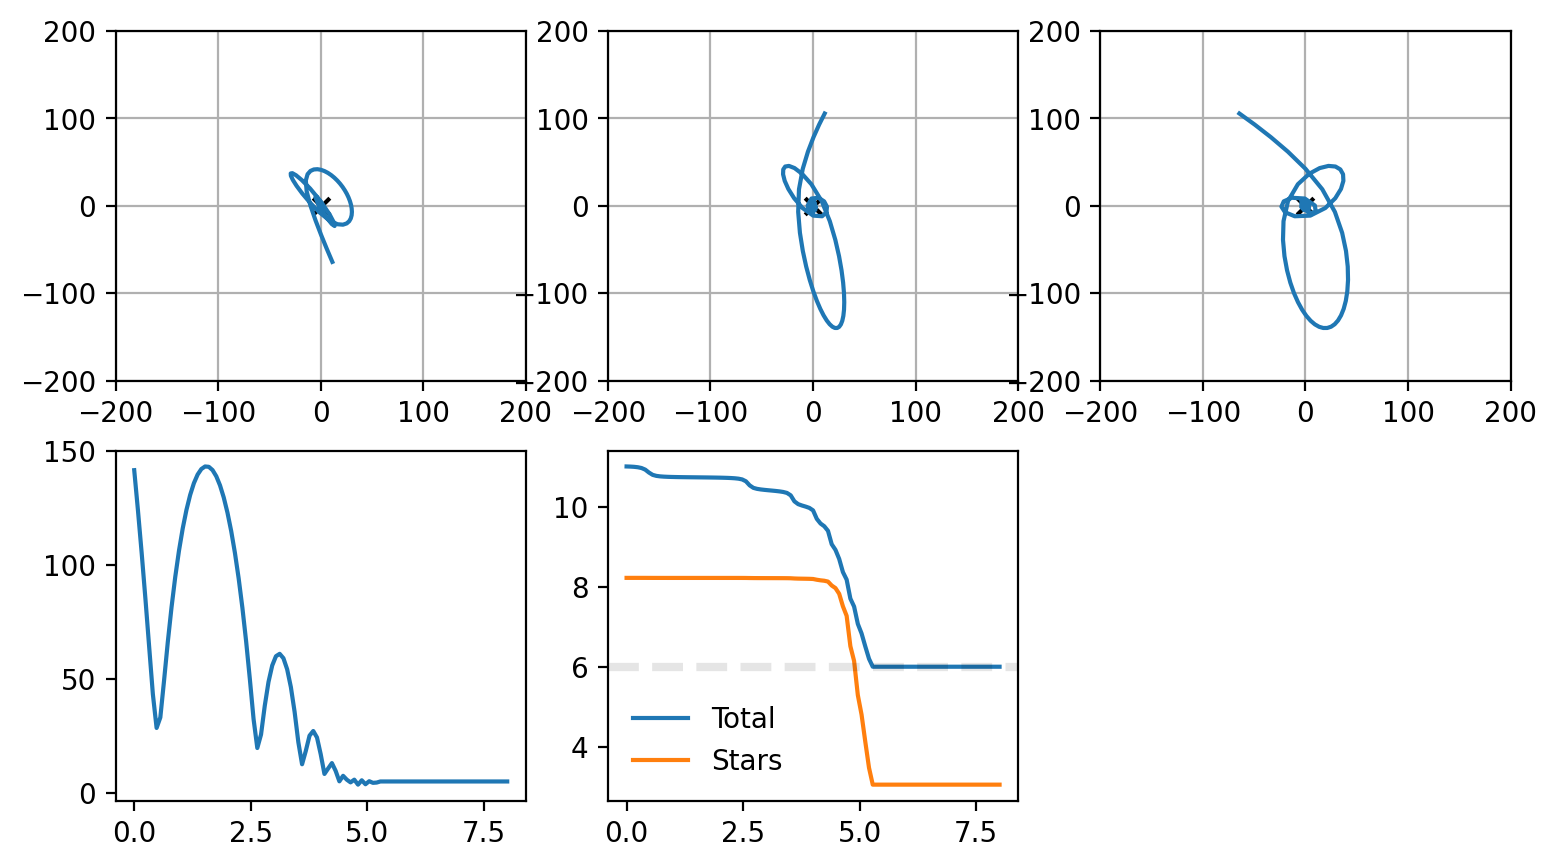

In [24]:
# Look at the results

R = solution['orbit'].xvArray[:,0]
P = solution['orbit'].xvArray[:,1]
Z = solution['orbit'].xvArray[:,2]

X = R*np.cos(P)
Y = R*np.sin(P)

pl.figure(figsize=(9,5))
ax1 = pl.subplot(2,3,1)
pl.plot(X,Y)

ax2 = pl.subplot(2,3,2)
pl.plot(X,Z)

ax3 = pl.subplot(2,3,3)
pl.plot(Y,Z)

ax4 = pl.subplot(2,3,4)
pl.plot(solution['tsteps'],solution['radii'])

ax5 = pl.subplot(2,3,5)
pl.plot(solution['tsteps'],np.log10(solution['prog_masses']),label='Total')
pl.plot(solution['tsteps'],np.log10(solution['prog_mstars']),label='Stars')

# This "resolution limit" phi_res is built in to the satgen orbit integrator;
# It can be adjusted by setting cfg.phi_res before the evolution calculation.
# The orbit is not updated after the total mass reaches this limit.
halo_mass_resolution_limit_rel = cfg.phi_res*prog.dens_profile.Mh
pl.axhline(np.log10(halo_mass_resolution_limit_rel),c='k',alpha=0.1,lw=3,ls='--')

# There is another "resolution limit"  built in to the satgen orbit integrator,
# cfg.Mres. In this case the limit is in absolute rather than relative mass.
# Again, the orbit is not updated after the total mass reaches this limit. 
# By default, cfg.Mres is None.
if cfg.Mres is not None:
    halo_mass_resolution_limit_abs = cfg.Mres
    pl.axhline(np.log10(halo_mass_resolution_limit_abs),c='g',alpha=0.1,lw=3,ls='--')

# Note that strange things happen if both limits are set and 
# cfg.Mres < cfg.phi_res * (initial halo mass)
    
pl.legend(frameon=False)

for ax in [ax1,ax2,ax3]:
    pl.sca(ax)
    pl.scatter([0],[0],c='k',marker='x')
    pl.grid()
    pl.xlim(-200,200)
    pl.ylim(-200,200)
    


(-1.0, 11.0)

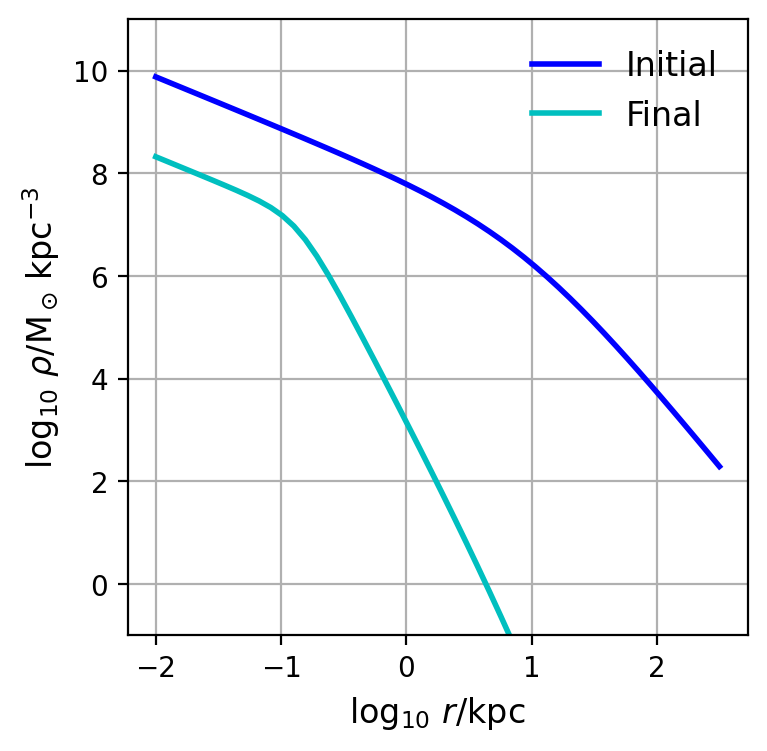

In [25]:
# Initial and final total density profile of the progenitor

pl.figure(figsize=(4,4))

log_r = np.logspace(-2,2.5)
log_rho = np.log10(prog.dens_profile.rho(log_r))
pl.plot(np.log10(log_r),log_rho,label='Initial',c='b',lw=2)

log_rho = np.log10(solution['prog_dp'].rho(log_r))
pl.plot(np.log10(log_r),log_rho,label='Final',c='c',lw=2)

pl.grid()
pl.xlabel(r'$\log_{10}\,r/\mathrm{kpc}$',fontsize=12)
pl.ylabel(r'$\log_{10}\,\rho/\mathrm{M_\odot \, kpc^{-3}}$',fontsize=12)
pl.legend(frameon=False,fontsize=12);
pl.ylim(-1,11)

## Example 2: Single progenitor from a merger tree

The list of progenitor IDs from the first tree, in decreasing order of mass:

In [26]:
prog_this_tree = np.flatnonzero(progenitors['TreeID'] == itree)

np.argsort(progenitors['ProgenitorMass'][prog_this_tree])[::-1]

array([163, 432, 351,  36, 244,  67, 195, 313, 433, 189, 314, 201, 434,
       377, 315, 254, 473, 245, 215, 119, 445, 246, 482, 290,  96, 352,
       403, 353, 122, 404, 168, 182, 316, 474, 458, 164, 216,  25,  48,
       281, 127, 483,  64, 462, 226,  89, 107,  74, 446, 101, 405, 406,
       150, 463,  75, 425, 378, 156,  37, 227, 255, 196, 407, 207, 304,
       128, 234, 459, 291,  20, 202, 208, 292,  50,  78, 272, 475, 165,
       256, 354, 282, 197, 157, 464, 161, 379, 355, 317, 293, 356,  80,
        41, 318, 217,  16, 319, 320, 228, 294, 426, 321,  21,   2, 235,
       295, 468, 357, 273, 484, 322,  22, 212, 476, 296, 120, 485, 183,
        59, 267,  97, 134,  23, 247,  60, 174,   9,  98,  43,  99, 236,
        29, 102, 323, 380, 257,  54, 171,  49, 237,  13, 305, 184, 203,
       471, 381,  68,  82, 453,  83, 130, 185,  19, 358,   8,  11,  85,
       408, 486,  45,  81,  28,   0, 359, 409, 111, 454, 198, 121, 176,
       147, 258,  32, 360, 213, 435, 324, 218,  84, 238, 274, 29

In [27]:
# An example progenitor chosen from the list above

itree = 0
iprog = 426

prog_zred = progenitors['ProgenitorZred'][prog_this_tree]
prog_ilev = progenitors['ProgenitorIlev'][prog_this_tree] 
prog_mass = progenitors['ProgenitorMass'][prog_this_tree]

host_mass = tree_main_branch_masses[itree,:]

np.random.seed(2026)
host = Host(host_mass, tree_redshifts, cosmology)
prog = Progenitor(prog_mass[iprog], host, level=prog_ilev[iprog])

In [28]:
f"Infall lookback time: {prog.infall_t_lbk:2.1f} Gyr, log10 initial mass / Msol: {np.log10(prog.mass_init):2.1f}"

'Infall lookback time: 12.5 Gyr, log10 initial mass / Msol: 9.0'

In [29]:
# The total time from infall to z=0
total_time_gyr = prog.infall_t_lbk
nsteps = 200

# tsteps grid and output array sizes will be nsteps+1,
# because the initial conditions are included at index zero (t=0)
tsteps = np.linspace(0, total_time_gyr, nsteps+1)

In [30]:
solution = evolve_orbit(host, prog, tsteps, evolve_prog_mass=True)

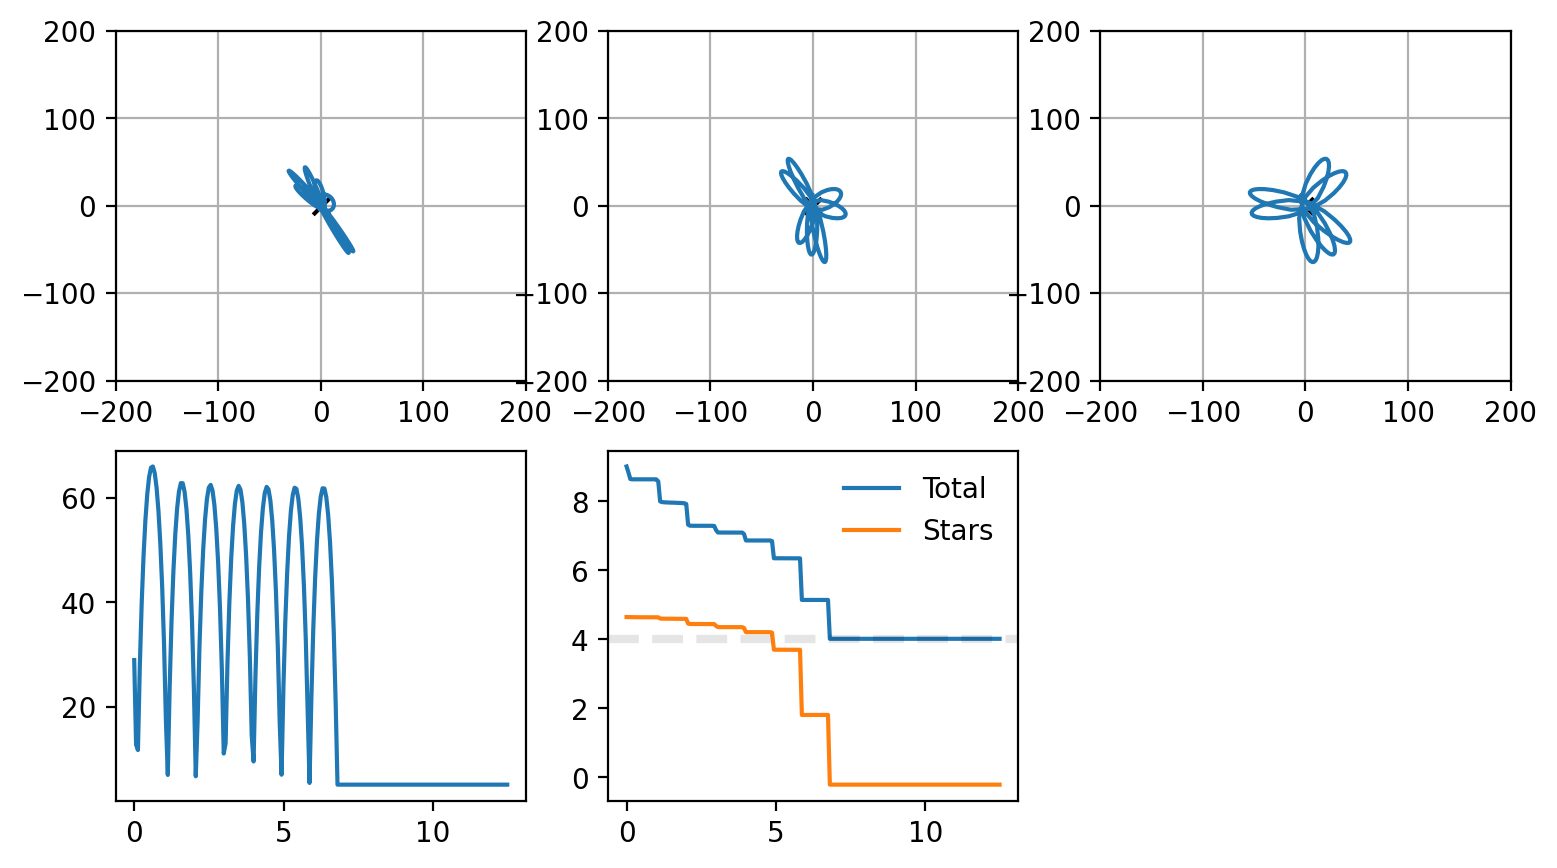

In [31]:
# Look at the results

R = solution['orbit'].xvArray[:,0]
P = solution['orbit'].xvArray[:,1]
Z = solution['orbit'].xvArray[:,2]

X = R*np.cos(P)
Y = R*np.sin(P)

pl.figure(figsize=(9,5))
ax1 = pl.subplot(2,3,1)
pl.plot(X,Y)

ax2 = pl.subplot(2,3,2)
pl.plot(X,Z)

ax3 = pl.subplot(2,3,3)
pl.plot(Y,Z)

ax4 = pl.subplot(2,3,4)
pl.plot(solution['tsteps'],solution['radii'])

ax5 = pl.subplot(2,3,5)
pl.plot(solution['tsteps'],np.log10(solution['prog_masses']),label='Total')
pl.plot(solution['tsteps'],np.log10(solution['prog_mstars']),label='Stars')

# This "resolution limit" phi_res is built in to the satgen orbit integrator;
# It can be adjusted by setting cfg.phi_res before the evolution calculation.
# The orbit is not updated after the total mass reaches this limit.
halo_mass_resolution_limit_rel = cfg.phi_res*prog.dens_profile.Mh
pl.axhline(np.log10(halo_mass_resolution_limit_rel),c='k',alpha=0.1,lw=3,ls='--')

# There is another "resolution limit"  built in to the satgen orbit integrator,
# cfg.Mres. In this case the limit is in absolute rather than relative mass.
# Again, the orbit is not updated after the total mass reaches this limit. 
# By default, cfg.Mres is None.
if cfg.Mres is not None:
    halo_mass_resolution_limit_abs = cfg.Mres
    pl.axhline(np.log10(halo_mass_resolution_limit_abs),c='g',alpha=0.1,lw=3,ls='--')

# Note that strange things happen if both limits are set and 
# cfg.Mres < cfg.phi_res * (initial halo mass)
    
pl.legend(frameon=False)

for ax in [ax1,ax2,ax3]:
    pl.sca(ax)
    pl.scatter([0],[0],c='k',marker='x')
    pl.grid()
    pl.xlim(-200,200)
    pl.ylim(-200,200)
    


To keep this notebook simple, the best (average) number of timesteps in the orbit integration and the difference between a finer timestep grid and finer interpolation of the main halo are dealt with elsewhere.

The need for some substepping (or interpolation) is shown by evolving the orbit on the time grid of the tree nodes -- notice there is no `tsteps` parameter in the call below. The default is to use the time grid defined by `host`.

In [32]:
solution = evolve_orbit(host, prog, evolve_prog_mass=True)

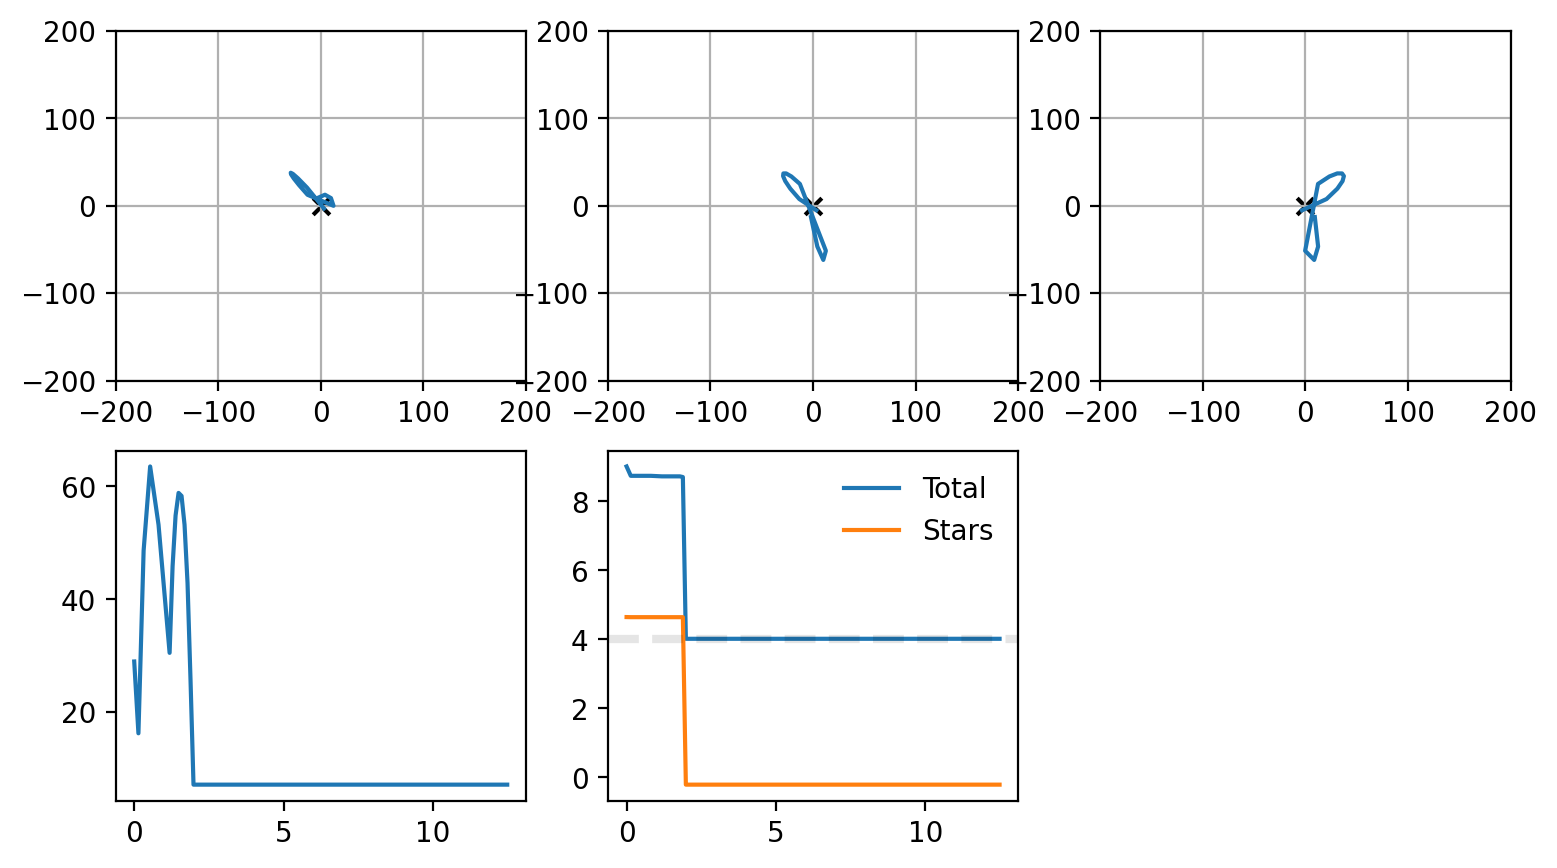

In [33]:
# Look at the results

R = solution['orbit'].xvArray[:,0]
P = solution['orbit'].xvArray[:,1]
Z = solution['orbit'].xvArray[:,2]

X = R*np.cos(P)
Y = R*np.sin(P)

pl.figure(figsize=(9,5))
ax1 = pl.subplot(2,3,1)
pl.plot(X,Y)

ax2 = pl.subplot(2,3,2)
pl.plot(X,Z)

ax3 = pl.subplot(2,3,3)
pl.plot(Y,Z)

ax4 = pl.subplot(2,3,4)
pl.plot(solution['tsteps'],solution['radii'])

ax5 = pl.subplot(2,3,5)
pl.plot(solution['tsteps'],np.log10(solution['prog_masses']),label='Total')
pl.plot(solution['tsteps'],np.log10(solution['prog_mstars']),label='Stars')

# This "resolution limit" phi_res is built in to the satgen orbit integrator;
# It can be adjusted by setting cfg.phi_res before the evolution calculation.
# The orbit is not updated after the total mass reaches this limit.
halo_mass_resolution_limit_rel = cfg.phi_res*prog.dens_profile.Mh
pl.axhline(np.log10(halo_mass_resolution_limit_rel),c='k',alpha=0.1,lw=3,ls='--')

# There is another "resolution limit"  built in to the satgen orbit integrator,
# cfg.Mres. In this case the limit is in absolute rather than relative mass.
# Again, the orbit is not updated after the total mass reaches this limit. 
# By default, cfg.Mres is None.
if cfg.Mres is not None:
    halo_mass_resolution_limit_abs = cfg.Mres
    pl.axhline(np.log10(halo_mass_resolution_limit_abs),c='g',alpha=0.1,lw=3,ls='--')

# Note that strange things happen if both limits are set and 
# cfg.Mres < cfg.phi_res * (initial halo mass)
    
pl.legend(frameon=False)

for ax in [ax1,ax2,ax3]:
    pl.sca(ax)
    pl.scatter([0],[0],c='k',marker='x')
    pl.grid()
    pl.xlim(-200,200)
    pl.ylim(-200,200)
    